МФТИ ФИВТ: Курс Машинное Обучение (осень, 2016), Арсений Ашуха, ars.ashuha@gmail.com

<h1 align="center">Organization Info</h1> 

**Дополнительный материал для выполнения дз**:
- Hastie, The Elements of Statistical Learning, https://goo.gl/k3wfEU, 10 Boosting and Additive Trees 337
- Соколов, Семинары по композиционным методам, https://goo.gl/sn8RyJ, http://goo.gl/ajNTQy

**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2016_fall <номер_группы> <фамилия>``, к примеру -- ``ML2016_fall 401 ivanov``
- Выполненное дз сохраните в файл ``<фамилия>_<группа>_task<номер>.ipnb``, к примеру -- ``ivanov_401_task1.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2016_fall Question <Содержание вопроса>``

--------
- **PS1**: Мы используем автоматические фильтры, и просто не найдем ваше дз, если вы не аккуратно его подпишите.
- **PS2**: Напоминаем, что дедлайны жесткие, письма пришедшие после автоматически удаляются =( чтобы соблазна не было 

<h1 align="center">Check Questions</h1> 

Ответе на вопросы своими словами (загугленный материал надо пересказать), ответ обоснуйте (напишите и ОБЪЯСНИТЕ формулки если потребуется), если не выходит, то вернитесь к лекции дополнительным материалам:

**Вопрос 1**: Чем отличается AdaBoost от XGBoost? Перечислите принципиальные отличия. 

XGBoost - градиентный бустинг. В Adaboost используется другой алгоритм подбора весов

**Вопрос 2**: Почему говорят, что AdaBoost неустойчив к выбросам?

Из-за использования экспоненциальной функции потерь.

**Вопрос 3**:  В каком пространстве градиентный бустинг совершает градиентный спуск? Какова размерность этого пространства?

В пространстве функций, являющихся суммой базовых алгоритмов.

**Вопрос 4**: В чем заключается сокращение шага в градиентном бустинге? Как число итераций, необходимое для сходимости, зависит от размера шага η?

Так как используется additive modelling то имеет смысл уменьшать шаг с увеличением номера шага(то есть при приближении к минимуму). Чем меньше длина шага, тем больше шагов требуется для схождения, но алгоритм становится более стабильным.

**Вопрос 5**: Что такое стохастический градиентный бустинг?

Использование батчей(подвыборок) для получения приближенного значения градиента вместо вычисления градиента по всей выборке

-----------
PS: Если проверяющий не понял ответ на большинство вопросов, то будет пичалька. Пишите так, чтобы можно было разобраться. 

<h1 align="center">Boosting</h1> 

1) Задача 1 
![](./img/task11.png)
![](./img/task12.png)

**<Решение>**

Покажем, как с помощью $2l + 2$ классификаторов можно верно предсказывать все объекты из обучающей выборки. Пусть задана обучающая выборка на прямой. Расставим $2l + 2$ решающих пней следующим образом: между каждыми двумя точками поставим два пня "в разные стороны". Плюс 2 по краям(Всего $2l + 2$). Таким образом, каждая из точек будет правильно классифицироваться накрывающими близлежащими классификаторами, а остальные взаимно уничтожаются.



Найдите градиент логистичиской функции потерь для фиксированного объекта


**<Решение>**
$ \frac{z*\exp(-y*z)}{(1 + \exp(-y*z))} $

<h1 align="center">Binary Boosting Implementation</h1> 

Нужно реализовать двухклассовый бустинг с логистичиской функцией потерь. 

Длину шага -- или используйте $1.0*lr$ или подбирайте одномерной оптимизацией;

In [1]:
%pylab inline

import warnings
import numpy as np
import pandas as pd
from copy import deepcopy
from utils import plot_surface
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.ensemble import GradientBoostingClassifier

warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
from multiprocessing import Pool

class BinaryBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators, lr=0.1, base_estimator=DecisionTreeRegressor()):
        self.lr = lr   
        self.n_estimators = n_estimators
        self.base_estimator = base_estimator
    
    def loss_grad(self, original_y, pred_y):
        ex = np.exp(-original_y * pred_y)
        return original_y * ex / (1 + ex)
        
    def fit(self, X, original_y):
        self.estimators_ = []
        
        base_prediction = deepcopy(self.base_estimator).fit(X, original_y)
        self.estimators_.append(base_prediction)
        
        for i in range(self.n_estimators):
            grad = self.loss_grad(original_y, self._predict(X))
            estimator = deepcopy(self.base_estimator).fit(X, -grad)
            self.estimators_.append(estimator)
        self.out_ = self.outliers(grad)

        return self

    def _predict(self, X):
        combination = map(lambda x: x.predict(X)*self.lr, self.estimators_)
        rv = np.sum(combination, axis = 0)
        return rv
    
    def predict(self, X):
        vectd = np.vectorize(lambda x: 1 if 1/(1 + np.exp(x)) > 0.5 else -1)
        prediction = self._predict(X)
        y_pred = vectd(prediction)
        return y_pred
    
    def outliers(self, grad):
        return np.argsort(np.abs(grad))[-10:]

<h1 align="center">Simple test</h1> 

In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, n_features=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)
y = 2*(y-0.5)

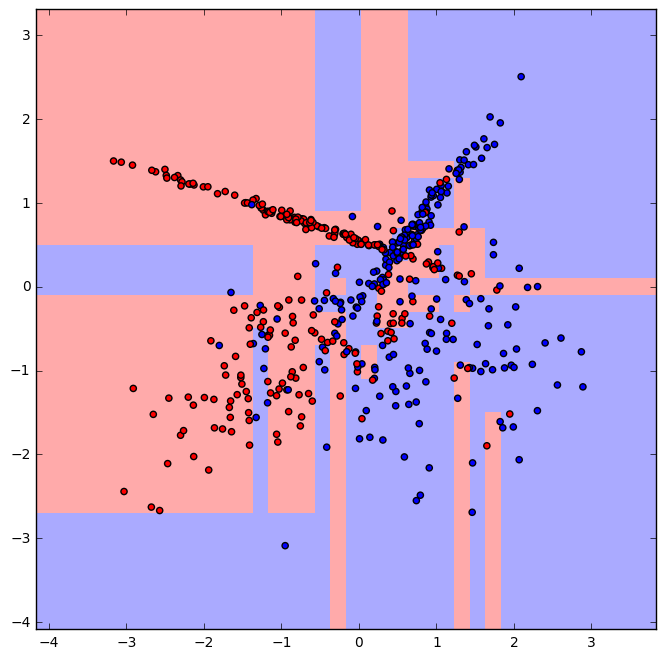

In [4]:
clf = BinaryBoostingClassifier(n_estimators=100).fit(X, y)
plot_surface(X, y, clf)

<h1 align="center">Outliers</h1> 

In [5]:
outliers_x = map(lambda x:x[0], X[clf.out_])
outliers_y = map(lambda x:x[1], X[clf.out_])
colormap = map(lambda x: 'red' if x == 1 else 'blue', y[clf.out_])

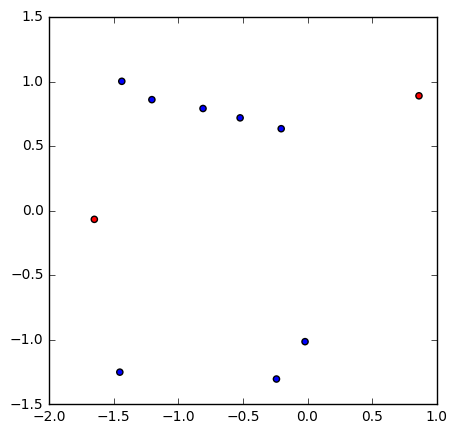

In [6]:
plt.figure(figsize=(5, 5))
plt.scatter(outliers_x, outliers_y, c=colormap)

<h1 align="center">Adult test</h1> 

In [7]:
#!sh ./get_data.sh

In [8]:
adult = pd.read_csv(
    './data/adult.data', 
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"], 
    header=None, na_values="?")
adult = pd.get_dummies(adult)
adult["Target"] = adult["Target_ >50K"]

In [9]:
X, y = adult[adult.columns[:-3]].values, adult[adult.columns[-1]].values
y = 2*(y-0.5)

In [10]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
binaryBoostingClassifier = BinaryBoostingClassifier(n_estimators=100).fit(X_train, y_train)

In [13]:
acc = accuracy_score(binaryBoostingClassifier.predict(X_train), y_train), accuracy_score(binaryBoostingClassifier.predict(X_test), y_test)
print 'accuracy score: ', acc

accuracy score:  (1.0, 0.81636162633583098)


In [14]:
gradientBoostingClassifier = GradientBoostingClassifier(n_estimators=100).fit(X_train, y_train)

In [16]:
gradacc = accuracy_score(gradientBoostingClassifier.predict(X_train), y_train),accuracy_score(gradientBoostingClassifier.predict(X_test), y_test)
print 'accuracy score: ', gradacc

accuracy score:  (0.86936936936936937, 0.86524996929124187)


<h1 align="center">Text classification</h1> 

- Найдите двухклассовый текстовый датасет (в качестве примера sentiment analysis) или возьмите многоклассовый и классифцируйте один клас против остальных
- Попробуйте бустинг на решающих деревьях, в качестве фичей используйте tf-idf и svd/random_projection/hashing_trick, что работает лучше? Сравните качество и время работы.

In [32]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
newsgroups_train = fetch_20newsgroups(subset='train', categories=['comp.sys.ibm.pc.hardware','comp.sys.mac.hardware'])
newsgroups_test = fetch_20newsgroups(subset='test', categories=['comp.sys.ibm.pc.hardware','comp.sys.mac.hardware'])

In [33]:
vectorizer = TfidfVectorizer()
X_train, y_train = vectorizer.fit_transform(newsgroups_train.data), newsgroups_train.target
X_test,  y_test  = vectorizer.transform(newsgroups_test.data), newsgroups_test.target

In [34]:
bbclf = BinaryBoostingClassifier(n_estimators=100, base_estimator=DecisionTreeRegressor()).fit(X_train, y_train)

In [35]:
print accuracy_score(bbclf.predict(X_train), y_train), accuracy_score(bbclf.predict(X_test), y_test)

0.494863013699 0.458172458172


<h1 align="center">Random Forest vs Boosting</h1> 

Подберите 2+ датасета как минимум большой и маленький (не использованных в этом дз) и проведите сравнение random forest и градиентного бустинга, используйте реализации алгоритмов из библиотеки sklearn.

- Опишите результаты, почему тот или другой алгоритм на конкретном датасете работает лучше/хуже?
- Как вы настраивали гиперпараметры алгоритмов?
- Как вы проверяли качесво алгоритмов?

In [58]:
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

def load_iris_dataset():
    iris = datasets.load_iris()
    X = iris.data[:, :2]
    y = iris.target
    return X, y

def load_cancer_dataset():
    cancer = datasets.load_breast_cancer()
    X = cancer.data
    y = cancer.target
    return X, y

In [59]:
X, y = load_iris_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y)
rfclf = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(X_train, y_train)
gradacc = accuracy_score(rfclf.predict(X_train), y_train),accuracy_score(rfclf.predict(X_test), y_test)
print 'random forest accuracy score: ', gradacc
gbclf = GradientBoostingClassifier(n_estimators=100).fit(X_train, y_train)
gradacc = accuracy_score(gbclf.predict(X_train), y_train), accuracy_score(gbclf.predict(X_test), y_test)
print 'gradient boosting accuracy score: ', gradacc

random forest accuracy score:  (0.9196428571428571, 0.78947368421052633)
gradient boosting accuracy score:  (0.9196428571428571, 0.73684210526315785)


In [60]:
X, y = load_cancer_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y)
rfclf = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(X_train, y_train)
gradacc = accuracy_score(rfclf.predict(X_train), y_train), accuracy_score(rfclf.predict(X_test), y_test)
print 'random forest accuracy score: ', gradacc
gbclf = GradientBoostingClassifier(n_estimators=100).fit(X_train, y_train)
gradacc = accuracy_score(gbclf.predict(X_train), y_train),accuracy_score(gbclf.predict(X_test), y_test)
print 'gradient boosting accuracy score: ', gradacc

random forest accuracy score:  (1.0, 0.95104895104895104)
gradient boosting accuracy score:  (1.0, 0.94405594405594406)


<h1 align="center">Bonus part</h1> 

Это удвоит баллы за дз.

- Реализуйте мультиклассовый бустинг -- проверьте на CIFAR10 + SVD
- Попробуйте различные функции потерь, придумайте несколько своих, удалось ли обойти логистичискую и экспоненциальную?